In [1]:
%matplotlib inline
import os.path
import sys
from inspect import getsourcefile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from sklearn import linear_model, datasets
import seaborn as sns
import statsmodels.api as sm

In [2]:
# Re-usable function to fit a number of different distribution types to loss data
def fit_plot_distribution(losses, dist_names):
    # Create dictionary to store variables of interest
    dist_fit_dict = {}
    
    # Set bins
    train_max_loss  = losses.max()
    train_min_loss  = losses.min()
    set_bins = np.logspace(np.log10(train_min_loss), np.log10(train_max_loss), 100)

    # Create figure to store distribution outputs
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xscale("log")
    y_bins, x_bins, _ = ax.hist(losses,
                            bins=set_bins,
                            facecolor='white',
                            ec='black')

    # Iterate through distributional forms, fit, add to graph and capture Likelihood and AIC information
    for dist_name in dist_names:
        dist = getattr(scipy.stats, dist_name)
        param = dist.fit(losses)
        likeL = np.sum(getattr(scipy.stats, dist_name).logpdf(losses,
                                                              *param[:-2],
                                                              loc=param[-2], 
                                                              scale=param[-1]) ) 
        cdf_fitted = dist.cdf(set_bins, *param[:-2], loc=param[-2], scale=param[-1]) * losses.size
        pdf_fitted = np.diff(cdf_fitted)
        ax.plot(np.mean([set_bins[1:],set_bins[:-1]], axis=0), pdf_fitted, label=dist_name)
        ax.legend(loc='upper right')
        dist_fit_dict[dist_name] = {"param": param}
        dist_fit_dict[dist_name].update({"likeL": likeL})
        dist_fit_dict[dist_name].update({"AIC": 2*len(param)-2*likeL})

    ax.set_xbound(lower = 0, upper = train_max_loss)
    ax.set_ybound(lower = 0, upper = y_bins.max()*1.1)
    return (fig, dist_fit_dict)

In [3]:
# Re-usable function to run logistical regressino on any combination of categorical and continuous variables
def fit_OLS(losses, treshold, **kwargs):
    
    if ('cat' in kwargs) and ('cont' in kwargs):
        dummy_var = pd.get_dummies(kwargs['cat'])
        all_var = pd.concat([dummy_var, kwargs['cont']], axis=1)
    elif 'cat' in kwargs:
        all_var = pd.get_dummies(kwargs['cat'])
    else:
        all_var = kwargs['cont']
        
    all_var = sm.add_constant(all_var, has_constant='add')
    ols_model = sm.OLS(losses, all_var)
    result = ols_model.fit()
    result.pvalues.sort_values().index
    df_result = pd.DataFrame(index=result.pvalues.sort_values().index,
                             data=result.pvalues.sort_values(),
                             columns=['p_value'])
    df_result = df_result[df_result.p_value <= treshold]
    
    loss_pred = result.predict(all_var)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(x=losses, y=loss_pred)
    ax.set_ybound(upper = loss_pred.max())
    ax.set_xbound(upper = losses.max())
    ax.set_title("Predicted vs. Actual losses")

    return (result.summary(), df_result, loss_pred, fig)

In [4]:
# Customizable function to transform loss data
def transform_losses(losses):
    return np.log(losses + 200)

In [5]:
# Import data set
train_file_loc = os.path.expanduser("~/Documents/springboard_files/springboard_cap1/data/train.csv")
train_data = pd.read_csv(train_file_loc)
train_data.head(5)

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


In [6]:
# Create series of losses
train_losses = train_data.loc[:,"loss"]
train_losses.head()

0    2213.18
1    1283.60
2    3005.09
3     939.85
4    2763.85
Name: loss, dtype: float64

In [7]:
# Check for completenes of data, returns 0 if there are entries for each loss data point
if sum(train_data.count(axis=0) != train_losses.size):
    print "Missing data mapped to losses"
else:
    print "No missing data mapped to losses"

No missing data mapped to losses


In [8]:
# Create separate DataFrames for continuous and categorical variables
cat_var = train_data.iloc[:,1:117]
cont_var = train_data.iloc[:,117:-1]

In [9]:
# For categorical variables, create dictionary of unique values
unique_dict = {}
for column in cat_var:
    unique_dict[column]=train_data[column].unique()

{'gamma': {'likeL': -1726929.7376061617, 'AIC': 3453865.4752123235, 'param': (10.661433756645422, -3926.4699877725598, 649.80285261782819)}, 'lognorm': {'likeL': -2053625.5649104214, 'AIC': 4107257.1298208428, 'param': (6.6359046458621869, 0.66999999999999993, 5.6910191758793047)}, 'exponnorm': {'likeL': -1675212.1225796209, 'AIC': 3350430.2451592418, 'param': (14.632851660167923, 510.60269858995923, 172.67550623626192)}, 'norm': {'likeL': -1768835.1807984014, 'AIC': 3537674.3615968027, 'param': (3037.3376856699833, 2904.0784757890747)}}


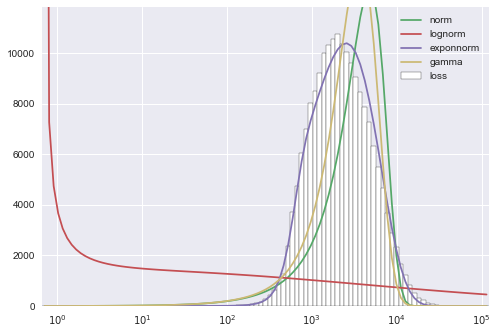

In [10]:
# List of distributional forms to explore
dist_names = ['norm','lognorm','exponnorm', 'gamma']#, 'beta','norm', 'beta', 'rayleigh', 'norm', 'pareto']

# Call function to plot distribution and return fit information
figure, dist_info = fit_plot_distribution(train_losses, dist_names)
print dist_info

{'gamma': {'likeL': -206290.60586129635, 'AIC': 412587.21172259271, 'param': (23.317622324270921, 4.2547835507734675, 0.15203323830549864)}, 'lognorm': {'likeL': -206421.20331965233, 'AIC': 412848.40663930465, 'param': (0.1347617545933199, 2.3776032713754747, 5.3732892140845294)}, 'exponnorm': {'likeL': -207634.30429812035, 'AIC': 415274.60859624069, 'param': (0.60245133111242888, 7.4207222324164084, 0.6292945348314064)}, 'norm': {'likeL': -208345.72403362161, 'AIC': 416695.44806724321, 'param': (7.7998370088715401, 0.73155126639190859)}}


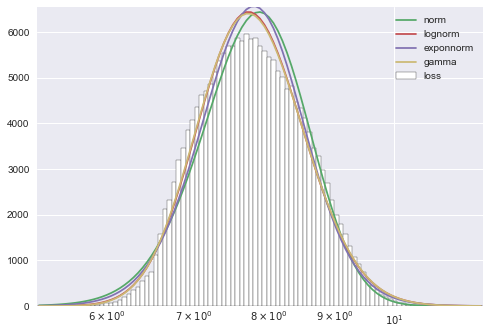

In [11]:
# Call function to plot transformed distribution and return fit information
dist_names = ['norm','lognorm','exponnorm', 'gamma']#, 'beta','norm', 'beta', 'rayleigh', 'norm', 'pareto']

figure, dist_info = fit_plot_distribution(transform_losses(train_losses), dist_names)
print dist_info

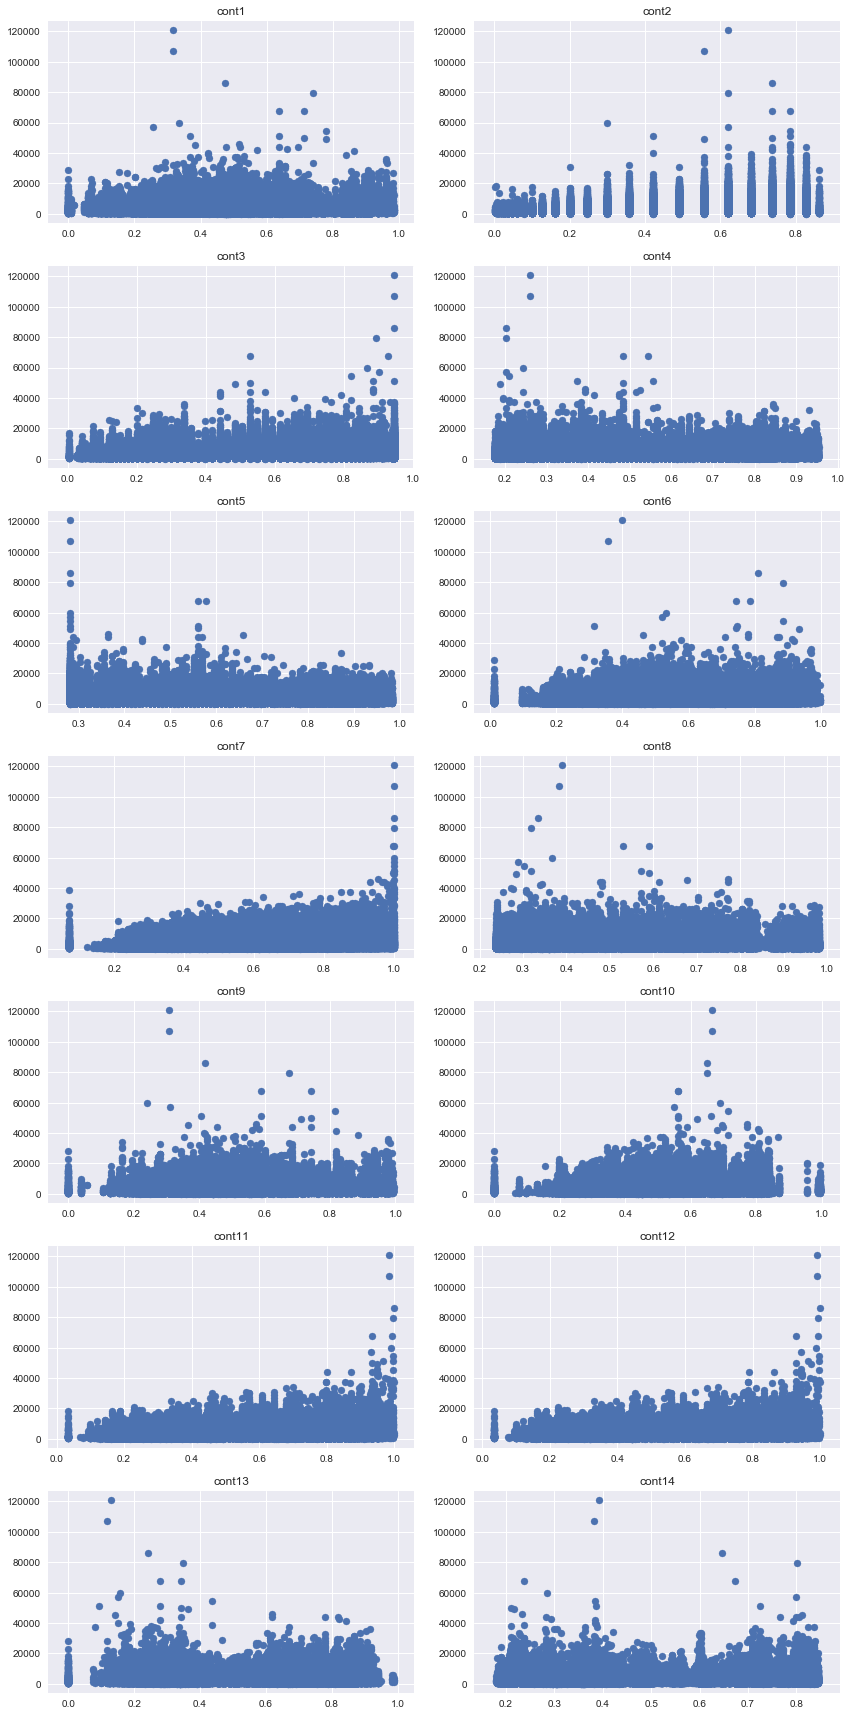

In [12]:
# Plot losses vs. continuous variables
fig, axes = plt.subplots(7,2, figsize=(12,24))

for counter, column in enumerate(cont_var):
    axes[counter // 2][counter % 2].scatter(x=column, y="loss", data=train_data)
    axes[counter // 2][counter % 2].set_title(column)

fig.tight_layout()

In [13]:
# Identify variables with a degree of correlatin > threshold (between themselves or vs. loss)
cont_var_wloss = pd.concat([cont_var, train_losses.to_frame(name = "loss")], axis=1)

threshold = 0.5
sig_dict = {}

sig_counter = 0
for counter1 in range(0, cont_var_wloss.columns.size):
    for counter2 in range(counter1 + 1, cont_var_wloss.columns.size):
        correl, pval = scipy.stats.pearsonr(cont_var_wloss.iloc[:,counter1], cont_var_wloss.iloc[:,counter2])
        if (correl<=-threshold) or (correl>=threshold):
            sig_dict[sig_counter] = {(cont_var_wloss.columns[counter1]):(cont_var_wloss.columns[counter2])}
            sig_counter += 1

sig_dict

{0: {'cont1': 'cont6'},
 1: {'cont1': 'cont9'},
 2: {'cont1': 'cont10'},
 3: {'cont1': 'cont11'},
 4: {'cont1': 'cont12'},
 5: {'cont1': 'cont13'},
 6: {'cont4': 'cont8'},
 7: {'cont6': 'cont7'},
 8: {'cont6': 'cont9'},
 9: {'cont6': 'cont10'},
 10: {'cont6': 'cont11'},
 11: {'cont6': 'cont12'},
 12: {'cont6': 'cont13'},
 13: {'cont7': 'cont11'},
 14: {'cont7': 'cont12'},
 15: {'cont9': 'cont10'},
 16: {'cont9': 'cont11'},
 17: {'cont9': 'cont12'},
 18: {'cont9': 'cont13'},
 19: {'cont10': 'cont11'},
 20: {'cont10': 'cont12'},
 21: {'cont10': 'cont13'},
 22: {'cont11': 'cont12'}}

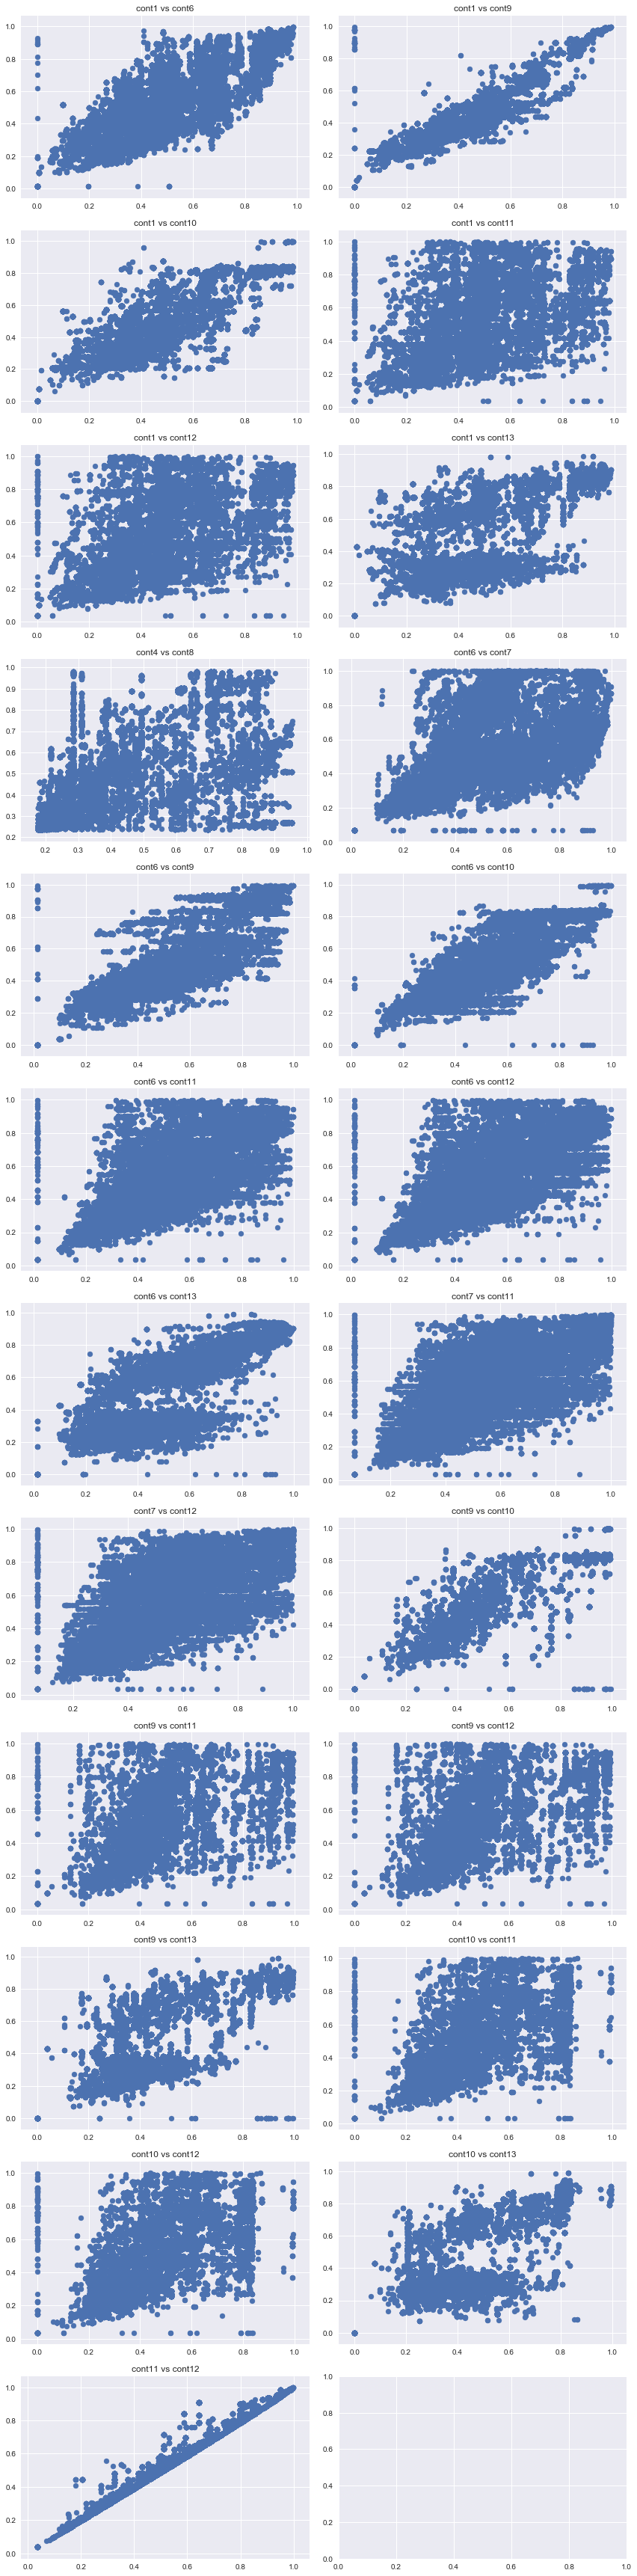

In [14]:
# Plot subset of continous variables and loss with a degree of correlation > threshold
fig, axes = plt.subplots(int(np.ceil((len(sig_dict)+1)/2)),2, figsize=(12,48))

for key, value in sig_dict.iteritems():
    title = ('{} vs {}').format(value.items()[0][0],  value.items()[0][1])
    axes[key // 2, key % 2].scatter(train_data[value.items()[0][0]], train_data[value.items()[0][1]])
    axes[key // 2, key % 2].set_title(title)

fig.tight_layout()

                            OLS Regression Results                            
Dep. Variable:                   loss   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     217.9
Date:                Sun, 02 Apr 2017   Prob (F-statistic):               0.00
Time:                        22:58:39   Log-Likelihood:            -1.6980e+06
No. Observations:              188318   AIC:                         3.398e+06
Df Residuals:                  187352   BIC:                         3.408e+06
Df Model:                         965                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const      -3.398e+12    2.2e+13     -0.154      0.8

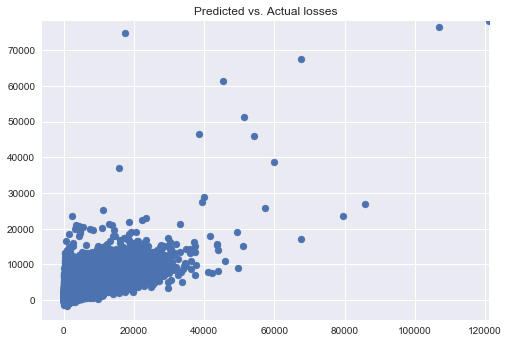

In [15]:
# Run all variables through OLS, identify variables with significance > threshold
summary_results, sig_variables, loss_pred, scatter_plot = fit_OLS(losses=train_losses,
                                         cont=cont_var,
                                         cat=cat_var,
                                         treshold=0.05)

# Print summary results and significant variables
print summary_results
print sig_variables

                            OLS Regression Results                            
Dep. Variable:                   loss   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     218.3
Date:                Sun, 02 Apr 2017   Prob (F-statistic):               0.00
Time:                        22:59:39   Log-Likelihood:            -1.6986e+06
No. Observations:              188318   AIC:                         3.399e+06
Df Residuals:                  187366   BIC:                         3.409e+06
Df Model:                         951                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const      -9.772e+12   2.32e+13     -0.421      0.6

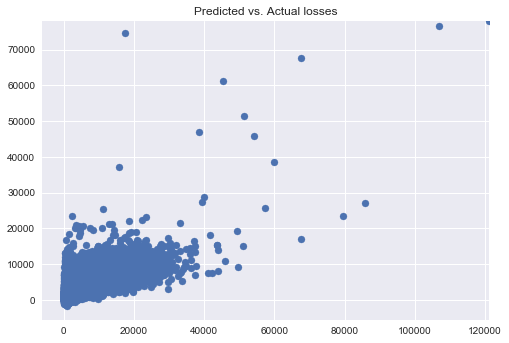

In [16]:
# Run categorical variables only
summary_results, sig_variables, loss_pred, scatter_plot = fit_OLS(losses=train_losses,
                                         cat=cat_var,
                                         treshold=0.05)

# Print summary results and significant variables
print summary_results
print sig_variables

                            OLS Regression Results                            
Dep. Variable:                   loss   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     562.5
Date:                Sun, 02 Apr 2017   Prob (F-statistic):               0.00
Time:                        22:59:41   Log-Likelihood:            -1.7650e+06
No. Observations:              188318   AIC:                         3.530e+06
Df Residuals:                  188303   BIC:                         3.530e+06
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       1477.3166     49.880     29.617      0.0

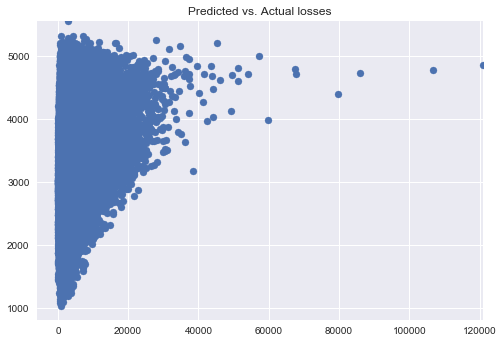

In [17]:
# Run continous variables only
summary_results, sig_variables, loss_pred, scatter_plot = fit_OLS(losses=train_losses,
                                         cont=cont_var,
                                         treshold=0.05)

# Print summary results and significant variables
print summary_results
print sig_variables

                            OLS Regression Results                            
Dep. Variable:                   loss   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     222.9
Date:                Sun, 02 Apr 2017   Prob (F-statistic):               0.00
Time:                        23:00:27   Log-Likelihood:            -1.3636e+05
No. Observations:              188318   AIC:                         2.746e+05
Df Residuals:                  187352   BIC:                         2.844e+05
Df Model:                         965                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const      -4.524e+09   5.52e+09     -0.820      0.4

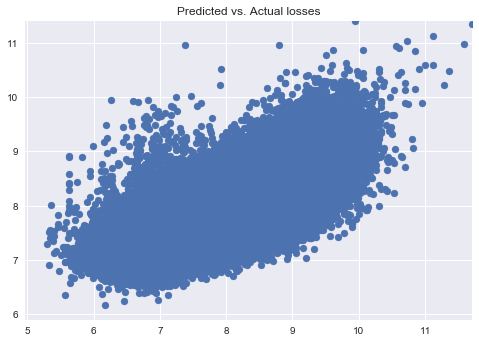

In [18]:
# Run all variables through OLS with transformed losses
summary_results, sig_variables, loss_pred, scatter_plot = fit_OLS(losses=transform_losses(train_losses),
                                         cont=cont_var,
                                         cat=cat_var,
                                         treshold=0.05)

# Print summary results and significant variables
print summary_results
print sig_variables